In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker
import numpy as np
from scipy.sparse import spdiags
import scipy as sp
from sympy import *
from sympy.physics.wigner import wigner_3j
import pandas as pd
from matplotlib import rc
import csv
import pylab as p

In [2]:
#The scalar potential
def V0(fields, parameters, rotation):
    La = parameters['Lambdas']
    ph = parameters['phases']
    nd = np.matmul(parameters['NDW'],rotation)
    return np.sum(La * np.cos(np.matmul(nd,fields) + ph))
#Its first derivative
def V1(fields, parameters, rotation):
    La = parameters['Lambdas']
    ph = parameters['phases']
    nd = np.matmul(parameters['NDW'],rotation)
    return np.matmul(-La * np.sin(np.matmul(nd,fields) + ph),nd)
#Its second derivative
def V2(fields, parameters, rotation):
    La = parameters['Lambdas']
    ph = parameters['phases']
    nd = np.matmul(parameters['NDW'],rotation)
    return np.matmul(nd.transpose(),np.matmul(np.diag(-La * np.cos(np.matmul(nd,fields) + ph)),nd))

#Generate a random orthogonal matrix
def Random_Rotation_Matrix(n):
    r = np.random.rand(n,n)
    return np.linalg.eig(r + r.transpose())[1]

#This function defines the equation of motion
def IVP_Function(t,state):
    positions = state[:N]
    velocities = state[N:]
    position_dot = velocities
    V1_eval = V1(positions, parameters, rotation)
    velocity_dot_heavy = -V1_eval[:N_fixed] * (m2[N_fixed]/m2[:N_fixed]) -velocities[:N_fixed] * (2 * m2[N_fixed]**0.5)
    velocity_dot_light = -V1_eval[N_fixed:] - 1.5 * velocities[N_fixed:]/t
    velocity_dot = np.concatenate((velocity_dot_heavy,velocity_dot_light))
    return np.concatenate((position_dot,velocity_dot))

In [97]:
#NUMBER OF AXIONS
N = 30

#TRIVIAL POTENTIAL
Trivial = False
#TRIVIAL INITIAL CONDITIONS:
TrivialIC = False

#FRACTIONAL DENSITY FLUCTUATION THRESHOLD FOR INTEGRATING OUT A PARTICLE
threshold = 0.01

#DOMAIN WALL NUMBERS (if not trivial)
NDW_range = 1 #Absolute value of the maximum domain wall number
p0 = 2/N #Probability that NDW = 0

#INSTANTONS
M = N**2 #Number of instantons
MUV = 1 #Scale of the UV physics
S0 = 1000 #scale of the instanton actions

#DECAY CONSTANTS
f2 = np.random.rand(N) * (1 - Trivial) + Trivial #Squared decay constants
R = Random_Rotation_Matrix(N) * (1 - Trivial) + Trivial * np.eye(N)

#Domain-wall numbers if random:
if Trivial:
    M = N + 0
    NDW_matrix = np.eye(N)
    phase_list = np.zeros([1,N])[0]
else:
    NDW_matrix = np.random.choice(range(-NDW_range,NDW_range + 1), size = (M,N), p = np.concatenate((0.5 * NDW_range**-1 * (1 - p0) * np.ones(NDW_range),p0 * np.ones(1),0.5 * NDW_range**-1 * (1 - p0) * np.ones(NDW_range))))
    phase_list = 2 * np.pi * np.random.rand(M)

#Packaging these parameters into a dictionary for easy reference
parameters = {'NDW' : NDW_matrix,
             'phases' : phase_list,
             'Lambdas' : MUV**4 * np.exp(-S0 * np.random.rand(M))}

#Computing the rotation matrices
rotation_rescale = np.matmul(R.transpose(),np.diag(f2**-0.5))
rotation_rescale_inv = np.matmul(np.diag(f2**0.5),R)

#We now pick the initial condition for the fields. For now, I will assume the fundamental fields to be randomly distributed from 0 to 2 pi
theta_i = 2 * np.pi * np.random.rand(N) * (1 - TrivialIC) + 0.25 * np.pi * TrivialIC
psi = np.matmul(rotation_rescale,theta_i)


In [133]:
#Regenerate the initial conditions
theta_i = 2 * np.pi * np.random.rand(N)
psi = np.matmul(rotation_rescale,theta_i)

In [ ]:
#Adjust the threshold
threshold = 0.1

In [98]:
#Set up the initial problem by rotating into a canonically normlized (local) mass basis
N_steps = 10000 #Number of t_i sized steps to take before checking whether to integrate out a mode

rho_list = np.zeros([N,3])#This keeps track of the energy densities, the time of decoupling, and the masses.

N_fixed = 0 #This variable will count the number of fields which we have integrated out -- initialized at 0
phi_fixed = np.zeros(0)

#Calculating the rotation to the mass eigenbasis
m2,S = np.linalg.eig(V2(psi, parameters, rotation_rescale))
#Mass Eigenbasis field at its initial condition
phi = np.matmul(S.transpose(),psi)

#Rotation matrix to the mass eigenbasis, as required for computing the gradient of the potential wrt the mass basis fields
rotation = np.matmul(rotation_rescale,S)

#Use the mass eigenvalues as an estimate for the initial integration time i.e. t_0 ~ 1/m_max
t_0 = 0.01/np.max(np.abs(m2)**0.5)

#Now define the initial value problem:
initial_state = np.concatenate((phi,np.zeros(N)))

t_i,t_step = t_0 + 0,N_steps * t_0
t_f = t_step + 0
max_step = 10 * t_0
while N_fixed < N:
    #Integrate the system for two decades beyond t = 1/m_max
    solution = sp.integrate.solve_ivp(IVP_Function, [t_i,t_f], initial_state, max_step = max_step)
    phi_of_t,phi_dot_of_t = solution.y[:N].transpose(),solution.y[N:].transpose()
    
    #We now compute the energy density using the mass eigenvalues computed
    lt = len(solution.t)#//2
    t_list,rho_m = solution.t[-lt:],np.zeros([lt,N])
    m2,S = np.linalg.eig(V2(phi_of_t[-1], parameters, rotation))
    idx = np.argsort(np.abs(m2))[::-1]
    m2,S = m2[idx],S[:,idx]
    rotation = np.matmul(rotation,S)
    i = -lt
    for t in solution.t[-lt:]:
        phi,phi_dot = np.matmul(S.transpose(),phi_of_t[i]),np.matmul(S.transpose(),phi_dot_of_t[i])
        delta_phi = V1(phi, parameters, rotation)
        rho_m[i] = 0.5 * (phi_dot**2 + m2**-1 * delta_phi**2)
        i += 1
    # for j in range(N_fixed,N):
    #     plt.plot(np.log10(t_list),np.log10(rho_m[:,j] * t_list**1.5),color = plt.colormaps['Dark2'](j))
    FDF = np.std(rho_m[:,N_fixed] * t_list**1.5)/np.mean(rho_m[:,N_fixed] * t_list**1.5)
    initial_state = np.concatenate((phi,phi_dot))
    if any(np.imag(m2)) != 0:
        break
    if FDF > threshold:
        t_i,t_f = t_f + 0,t_f + t_step
    elif N_fixed < N:
        rho_list[N_fixed,:] = np.array([rho_m[-1,N_fixed],t_f,m2[N_fixed]**0.5])
        max_step = 0.01 * m2[N_fixed]**-0.5
        N_fixed += 1
        t_step = N_steps * 0.1 * max_step
        t_i,t_f = t_f + 0,t_f + t_step
        print(N_fixed,max_step)
    else:
        break

/var/folders/bj/2sxxmcw51675p0sgmwt6jctr0000gn/T/ipykernel_79179/1789437548.py:31: RuntimeWarning: invalid value encountered in scalar power
  velocity_dot_heavy = -V1_eval[:N_fixed] * (m2[N_fixed]/m2[:N_fixed]) -velocities[:N_fixed] * (2 * m2[N_fixed]**0.5)


1 0.0015033743269950866
2 0.004323635710384103
3 0.012132208910837829
4 0.018422137129409717
5 0.02490702339785321
6 0.031967389468849715
7 0.18126073279273988
8 0.25548066424047183
9 0.4510241656016137
10 0.8450823354480441
11 5.513479180932014
12 6.833267306415637
13 21.18723433439514
14 41.69813453596835
15 59.86149861923416
16 216.49499150918618
17 369.6931274622823
18 395.93481366328103
19 665.0499193834434
20 946.3618411742555
21 4315.441703661552
22 9760.986753680063
23 9803.817898364814
24 12908.377919259414
25 34420.45547363241
26 67960.16546190463
27 75471.17004399837
28 153062.34603486297
29 235680.4635026379
30 900348.3702189636


In [99]:
rho_normalized = np.zeros([N,2])
for i in range(N):
    rho_normalized[i] = [rho_list[i,2],rho_list[i,0] * (rho_list[i,1]/rho_list[-1,1])**1.5]

Text(0, 0.5, 'log energy density [arbitrary units]')

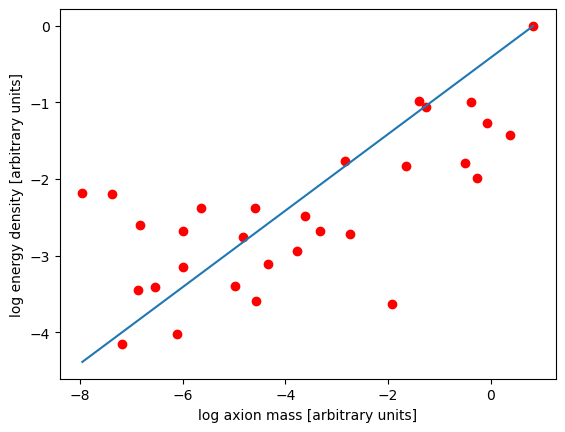

In [100]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

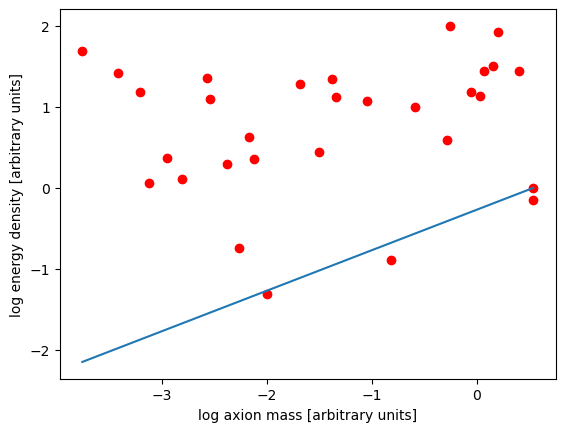

In [92]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

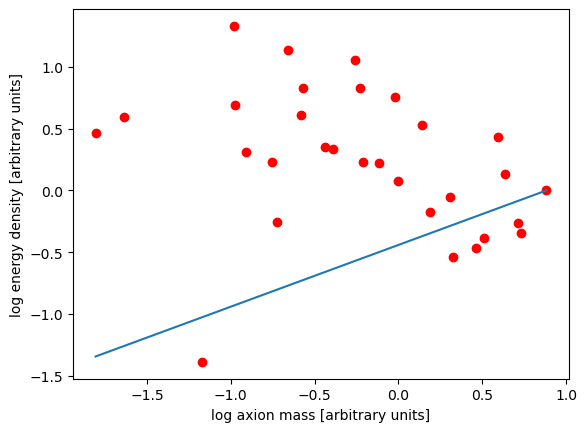

In [82]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

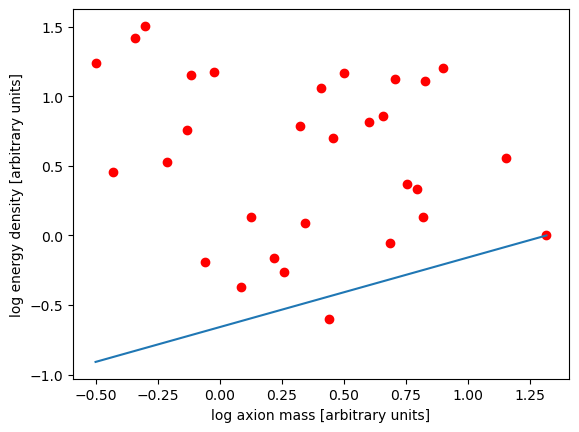

In [78]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

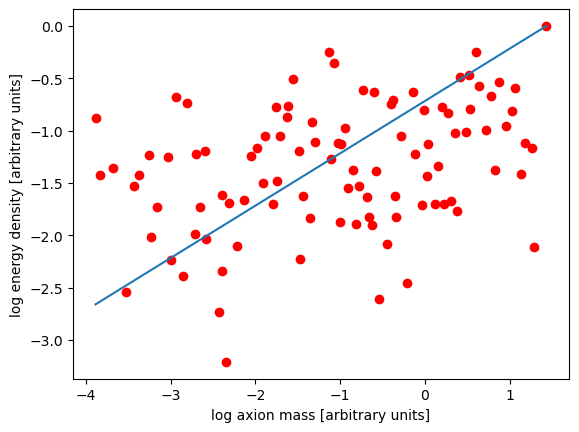

In [58]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

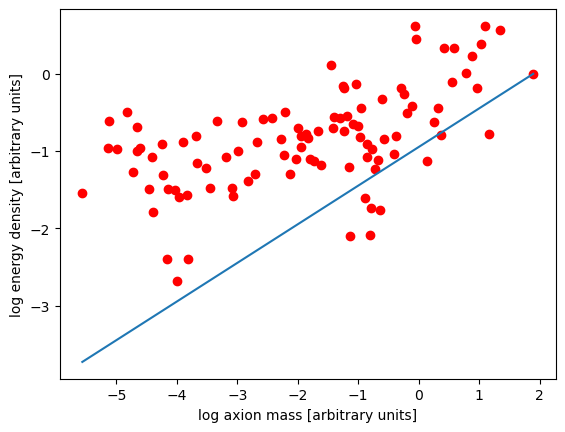

In [56]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

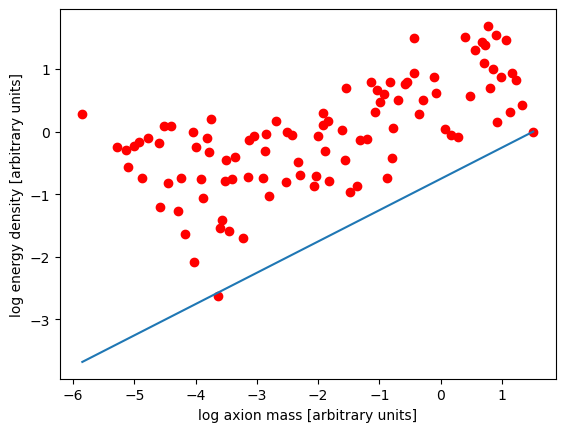

In [45]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

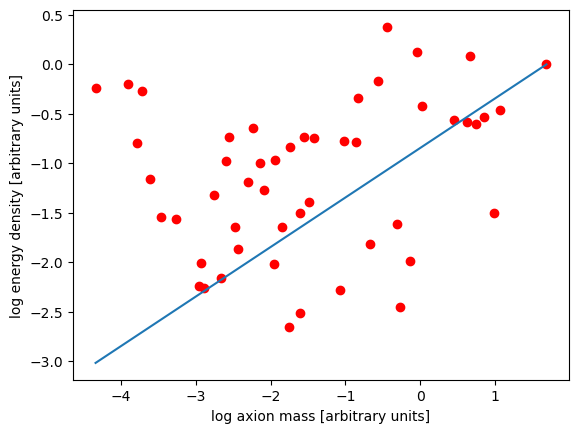

In [31]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

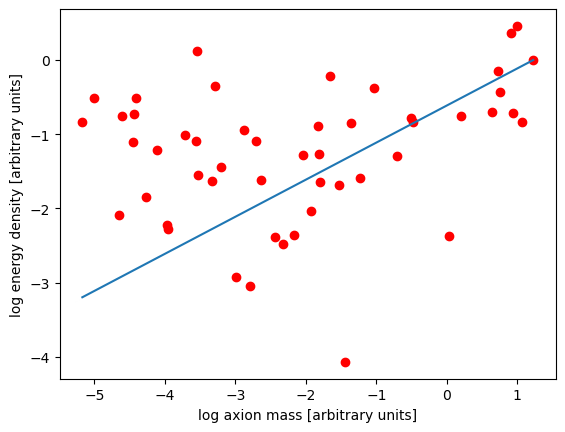

In [27]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

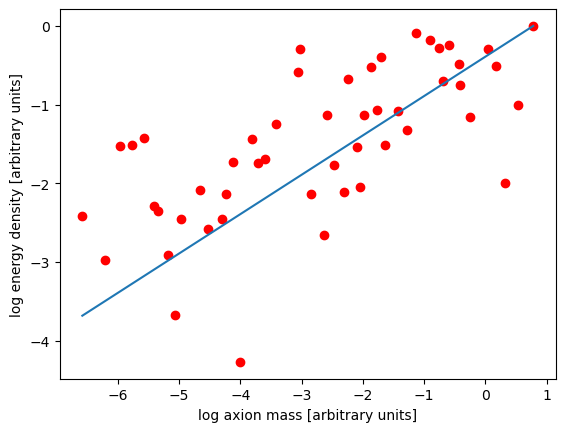

In [54]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

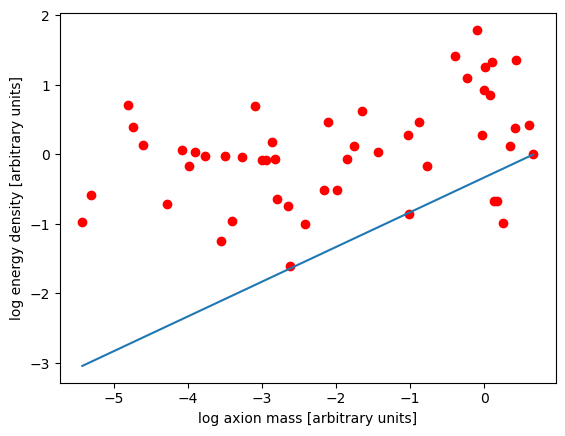

In [52]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

Text(0, 0.5, 'log energy density [arbitrary units]')

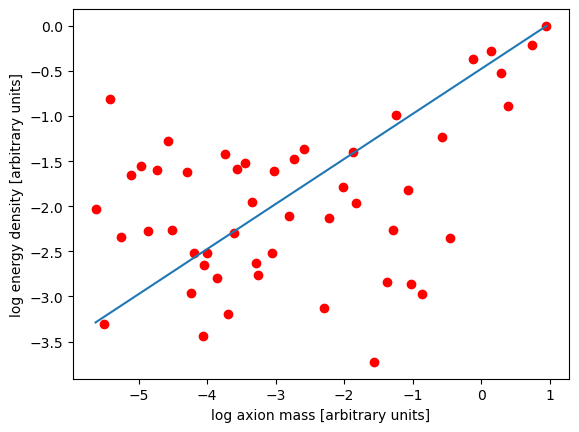

In [25]:
ax=plt.subplot()
plt.plot(np.log10(rho_normalized[:,0]),np.log10(rho_normalized[:,1]/rho_normalized[0,1]),'ro')
plt.plot(np.log10(rho_normalized[:,0]),np.log10((rho_normalized[:,0]/rho_normalized[0,0])**0.5 ))
ax.set_xlabel('log axion mass [arbitrary units]')
ax.set_ylabel('log energy density [arbitrary units]')

In [154]:
#FRACTIONAL DENSITY FLUCTUATION THRESHOLD FOR INTEGRATING OUT A PARTICLE
FDF = 0.01

#NUMBER OF AXIONS
N = 10

#DOMAIN WALL NUMBERS
NDW_range = 1 #Absolute value of the maximum domain wall number
p0 = 0.5 #Probability that NDW = 0

#INSTANTONS
M = 15 #Number of instantons
MUV = 1 #Scale of the UV physics
S0 = 10 #scale of the instanton actions

#DECAY CONSTANTS
f2 = np.random.rand(N) #Squared decay constants
R = Random_Rotation_Matrix(N)

#Packaging these parameters into a dictionary for easy reference
parameters = {'NDW' : np.random.choice(range(-NDW_range,NDW_range + 1), size = (M,N), p = np.concatenate((0.5 * NDW_range**-1 * (1 - p0) * np.ones(NDW_range),p0 * np.ones(1),0.5 * NDW_range**-1 * (1 - p0) * np.ones(NDW_range)))),
             'phases' : 2 * np.pi * np.random.rand(M),
             'Lambdas' : MUV**4 * np.exp(-S0 * np.random.rand(M))}

#Computing the rotation matrices
rotation_rescale = np.matmul(R.transpose(),np.diag(f2**-0.5))
rotation_rescale_inv = np.matmul(np.diag(f2**0.5),R)

#We now pick the initial condition for the fields. For now, I will assume the fundamental fields to be randomly distributed from 0 to 2 pi
theta_i = 2 * np.pi * np.random.rand(N)
psi = np.matmul(rotation_rescale,theta_i)

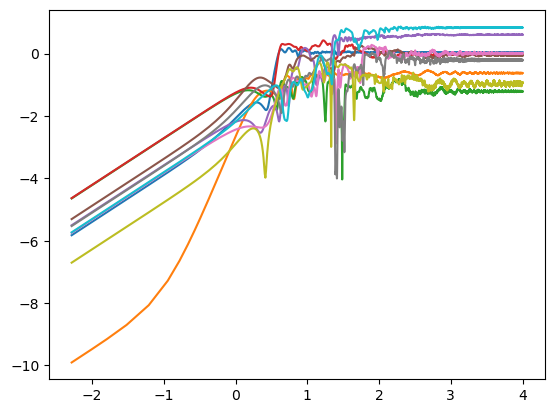

In [177]:




#Set up the initial problem by rotating into a canonically normlized (local) mass basis
N_steps = 10000 #Number of t_i sized steps to take before checking whether to integrate out a mode
threshold = 0.01

N_fixed = 0 #This variable will count the number of fields which we have integrated out -- initialized at 0
phi_fixed = np.zeros(0)

#Calculating the rotation to the mass eigenbasis
m2,S = np.linalg.eig(V2(psi, parameters, rotation_rescale))

#Rotation matrix to the mass eigenbasis, as required for computing the gradient of the potential wrt the mass basis fields
rotation = np.matmul(rotation_rescale,S)
#Mass Eigenbasis field at its initial condition
phi = np.matmul(S.transpose(),psi)

#Use the mass eigenvalues as an estimate for the initial integration time i.e. t_0 ~ 1/m_max
t_0 = 0.01/np.max(np.abs(m2)**0.5)

#Now define the initial value problem:
initial_state = np.concatenate((phi,np.zeros(N)))

t_i,t_step = t_0 + 0,N_steps * t_0
t_f = t_step + 0
max_step = 10 * t_0


solution = sp.integrate.solve_ivp(IVP_Function, [t_i,10000], initial_state, max_step = max_step)
rho_k = np.zeros([len(solution.t),N])
rho_m = np.zeros([len(solution.t),N])

M2 = V2(solution.y[:N,-1], parameters, rotation)
m2,S = np.linalg.eig(M2)
idx = np.argsort(m2)[::-1]
m2,S = m2[idx],S[:,idx]
rotation = np.matmul(rotation,S)
i = 0
for t in solution.t:
    delta_phi = V1(np.matmul(S.transpose(),solution.y[:N,i]), parameters, rotation)
    rho_k[i] = 0.5 * np.matmul(S.transpose(),solution.y[N:,i])**2
    rho_m[i] = 0.5 * m2**-1 * delta_phi**2
    i += 1
for j in range(N):
    # plt.plot(np.log10(solution.t),np.log10(rho_m[:,j]))
    # plt.plot(np.log10(solution.t),np.log10(rho_k[:,j]))
    plt.plot(np.log10(solution.t),np.log10(rho_k[:,j] + rho_m[:,j]) + np.log10(solution.t**1.5))

In [ ]:
for j in range(10):
    # plt.plot(np.log10(solution.t),np.log10(rho_m[:,j]))
    # plt.plot(np.log10(solution.t),np.log10(rho_k[:,j]))
    plt.plot(np.log10(solution.t),np.log10(rho_k[:,j] + rho_m[:,j]))

In [137]:
print(m2)

[7.85030376 1.25682694 0.84389151 0.16776591]


In [49]:
m2

array([3.52006851, 0.55783369, 0.19583515])

In [113]:
0.5 * phi_dot**2 + 0.5 * m2**-1 * delta_phi**2

array([  0.81189518,  -2.01901753, -17.86639894])

In [120]:
rho_m = np.zeros(N)

In [168]:
solution.y[:N,-1]

array([ -1.73508533, -11.818526  ,  -8.80801942])

In [193]:
phi[:,-1]

array([ -2.1193568 , -12.80293523,  -3.93771378])

In [213]:
m2,S = np.linalg.eig(V2(phi[:,0], parameters, rotation))

In [214]:
S

array([[ 0.77387187,  0.57956174,  0.25540267],
       [ 0.61016303, -0.7903399 , -0.05535274],
       [-0.16977459, -0.1986732 ,  0.96524896]])

In [196]:
m2

array([20.42299512,  7.20098125,  9.83837159])

In [200]:
phi[2]

array([-6.0269645 , -6.02696463, -6.02696837, ..., -5.99539756,
       -5.9954102 , -5.99541043])

In [240]:
V1(np.matmul(S.transpose(),phi[:,10050]), parameters, rotation)

array([ 0.00371521, -0.02620074, -0.04368917])

In [18]:
S

array([[ 0.91522037,  0.40146311,  0.03462727],
       [ 0.02519455,  0.0287533 , -0.99926897],
       [ 0.40216528, -0.91542374, -0.01620092]])

In [160]:
m2

array([1.30714111e+01, 3.61075587e+00, 1.72717502e+00, 2.51561944e-01,
       8.71305521e-02, 4.46726666e-02, 1.66179731e-02, 5.71044799e-03,
       1.45010606e-03, 6.78958250e-05])